In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import datetime as datetime
import torch
from GraphSAGE import SiameseGNN_GraphSAGE
from CreateFeatures import CreateFeatures
from functions import dist_labels_to_changepoint_labels
from torch_geometric.utils import k_hop_subgraph

In [3]:
countries = ['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD',
       'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA',
       'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB',
       'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA',
       'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FSM',
       'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC',
       'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI',
       'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA',
       'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KNA', 'KOR',
       'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LKA', 'LSO', 'LTU',
       'LUX', 'LVA', 'MAC', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL',
       'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MNP', 'MOZ', 'MRT',
       'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR',
       'NPL', 'NRU', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW',
       'PNG', 'POL', 'PRT', 'PRY', 'PSE', 'PYF', 'QAT', 'ROU', 'RUS',
       'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV', 'SMR',
       'SRB', 'SSD', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SWZ', 'SXM',
       'SYC', 'SYR', 'TCD', 'TGO', 'THA', 'TJK', 'TKM', 'TLS', 'TON',
       'TTO', 'TUN', 'TUR', 'TUV', 'TZA', 'UGA', 'UKR', 'URY', 'USA',
       'UZB', 'VCT', 'VEN', 'VNM', 'VUT', 'WSM', 'YEM', 'ZAF', 'ZMB',
       'ZWE']

In [35]:
with open("../pygcn/all_graphs.pkl", "rb") as f:         
    all_graphs = pkl.load(f)

In [36]:
def load_model(model_path: str):

    model = SiameseGNN_GraphSAGE(50, 27, dropout = 0.05, nhidden=16)
    model.load_state_dict(torch.load(model_path))

    return model

In [37]:
model = load_model('../../models/real_data/mis_norm_with_gdp.pt')
model.eval()

SiameseGNN_GraphSAGE(
  (gnn): GraphSAGE(
    (conv1): SAGEConv(27, 128, aggr=mean)
    (conv2): SAGEConv(128, 16, aggr=mean)
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dropout): Dropout(p=0.05, inplace=False)
  (similarity): PairwiseDistance()
  (fc1): Linear(in_features=50, out_features=128, bias=True)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [38]:
with open("../pygcn/all_graphs.pkl", "rb") as f:         
    all_graphs = pkl.load(f)

In [39]:
with open("../../feature_dicts/mis_norm.pkl", "rb") as f:
    feat_dict = pkl.load(f)

In [40]:
def add_features(years, graphs, feat_dict, dim):

    zeros = torch.zeros(dim)

    for i in range(len(years)):
        new_x = torch.empty(0, dim)
        year = years[i]
        
        feat_dict_year = feat_dict[year].combined_features

        for j, country in enumerate(countries):
            if j == 0:
                new_x = torch.stack([zeros])

            elif country in feat_dict_year["country_code"].values:
                tensor_before = graphs[i].x[j]
                country_row = feat_dict_year[feat_dict_year["country_code"] == country]
                country_row = country_row.drop(columns = ["country_code", "current_gdp_growth"])
                row_values = country_row.values.tolist()
                row_tensor = torch.tensor(row_values)[0]
                combined_values = torch.cat((tensor_before, row_tensor))

                new_x = torch.cat((new_x, combined_values.unsqueeze(0)), dim=0)

            else:
                new_x = torch.cat((new_x, zeros.unsqueeze(0)), dim=0)

        graphs[i].x = new_x

    return graphs

In [41]:
years = range(1962,2019)
all_graphs = add_features(years, all_graphs, feat_dict, 27)

In [42]:
indices_by_country = {}
for i in countries:
    index = countries.index(i)
    index_np = np.int32(index)
    indices_by_country[i] = index_np

In [70]:
indices_by_country

{'ABW': 0,
 'AFG': 1,
 'AGO': 2,
 'ALB': 3,
 'AND': 4,
 'ARE': 5,
 'ARG': 6,
 'ARM': 7,
 'ASM': 8,
 'ATG': 9,
 'AUS': 10,
 'AUT': 11,
 'AZE': 12,
 'BDI': 13,
 'BEL': 14,
 'BEN': 15,
 'BFA': 16,
 'BGD': 17,
 'BGR': 18,
 'BHR': 19,
 'BHS': 20,
 'BIH': 21,
 'BLR': 22,
 'BLZ': 23,
 'BMU': 24,
 'BOL': 25,
 'BRA': 26,
 'BRB': 27,
 'BRN': 28,
 'BTN': 29,
 'BWA': 30,
 'CAF': 31,
 'CAN': 32,
 'CHE': 33,
 'CHL': 34,
 'CHN': 35,
 'CIV': 36,
 'CMR': 37,
 'COD': 38,
 'COG': 39,
 'COL': 40,
 'COM': 41,
 'CPV': 42,
 'CRI': 43,
 'CUB': 44,
 'CUW': 45,
 'CYM': 46,
 'CYP': 47,
 'CZE': 48,
 'DEU': 49,
 'DMA': 50,
 'DNK': 51,
 'DOM': 52,
 'DZA': 53,
 'ECU': 54,
 'EGY': 55,
 'ESP': 56,
 'EST': 57,
 'ETH': 58,
 'FIN': 59,
 'FJI': 60,
 'FRA': 61,
 'FSM': 62,
 'GAB': 63,
 'GBR': 64,
 'GEO': 65,
 'GHA': 66,
 'GIN': 67,
 'GMB': 68,
 'GNB': 69,
 'GNQ': 70,
 'GRC': 71,
 'GRD': 72,
 'GRL': 73,
 'GTM': 74,
 'GUM': 75,
 'GUY': 76,
 'HKG': 77,
 'HND': 78,
 'HRV': 79,
 'HTI': 80,
 'HUN': 81,
 'IDN': 82,
 'IND': 83,
 '

In [73]:
sub_graphs_wo_country = []
with open("../pygcn/all_graphs.pkl", "rb") as f:         
    all_graphs = pkl.load(f)
    all_graphs = add_features(years, all_graphs, feat_dict, 27)
    for i in range(len(years)):
        example_edge_index = all_graphs[i].edge_index
        edge_index = example_edge_index.to(torch.int32)
        ex_node = indices_by_country['CHN']
            
        mask = ~((example_edge_index[0] == ex_node) | (example_edge_index[1] == ex_node))
        temp_graph = all_graphs[i]
        temp_graph.edge_index = temp_graph.edge_index[:, mask]
        sub_graphs_wo_country.append(temp_graph)

In [75]:
sub_graphs_wo_country

[Data(x=[199, 27], edge_index=[2, 4355], edge_attr=[4420], y=[199]),
 Data(x=[199, 27], edge_index=[2, 4835], edge_attr=[4911], y=[199]),
 Data(x=[199, 27], edge_index=[2, 5145], edge_attr=[5228], y=[199]),
 Data(x=[199, 27], edge_index=[2, 5574], edge_attr=[5667], y=[199]),
 Data(x=[199, 27], edge_index=[2, 5711], edge_attr=[5807], y=[199]),
 Data(x=[199, 27], edge_index=[2, 5813], edge_attr=[5916], y=[199]),
 Data(x=[199, 27], edge_index=[2, 5939], edge_attr=[6037], y=[199]),
 Data(x=[199, 27], edge_index=[2, 6048], edge_attr=[6143], y=[199]),
 Data(x=[199, 27], edge_index=[2, 6502], edge_attr=[6617], y=[199]),
 Data(x=[199, 27], edge_index=[2, 6624], edge_attr=[6740], y=[199]),
 Data(x=[199, 27], edge_index=[2, 6976], edge_attr=[7112], y=[199]),
 Data(x=[199, 27], edge_index=[2, 7429], edge_attr=[7574], y=[199]),
 Data(x=[199, 27], edge_index=[2, 7927], edge_attr=[8090], y=[199]),
 Data(x=[199, 27], edge_index=[2, 7970], edge_attr=[8141], y=[199]),
 Data(x=[199, 27], edge_index=[2, 

In [44]:
crisis_years = [1962, 1967, 1973, 1978, 1981, 1989, 1993, 1996, 2002, 2007, 2012, 2014, 2016]
phases = []
p = -1
for i in range(1962,2019):
    if i in crisis_years:
        p += 1
    phases.append(p)

cp_times = [t-1962 for t in crisis_years]
labels = dist_labels_to_changepoint_labels(phases)

In [74]:
import json
with open(f'../../results/explain_graphs/ctry-CHN-graph.p', 'wb') as f:
    pkl.dump(sub_graphs_wo_country, f)

with open(f'../../results/explain_graphs/ctry-CHN-labels.p', 'wb') as f:
    pkl.dump(labels, f)

with open(f'../../results/explain_graphs/cp-times.json', 'w') as f:
    json.dump(cp_times, f)

In [56]:
change_points = {}
similarity_scores_norm_gdp = {}

with open(f"../../results/explain_graphs/results/NCPD_02_27_03:23:03_window_2_detection/avg_similarity.p", 'rb') as file:
    avg_sim = pkl.load(file)
    similarity_scores_norm_gdp['USA'] = avg_sim

with open(f"../../results/explain_graphs/results/NCPD_02_27_03:23:03_window_2_detection/est_cps.p", 'rb') as file:
    cps = pkl.load(file)
    adj = [i+1962 for i in cps]
    change_points['USA'] = adj

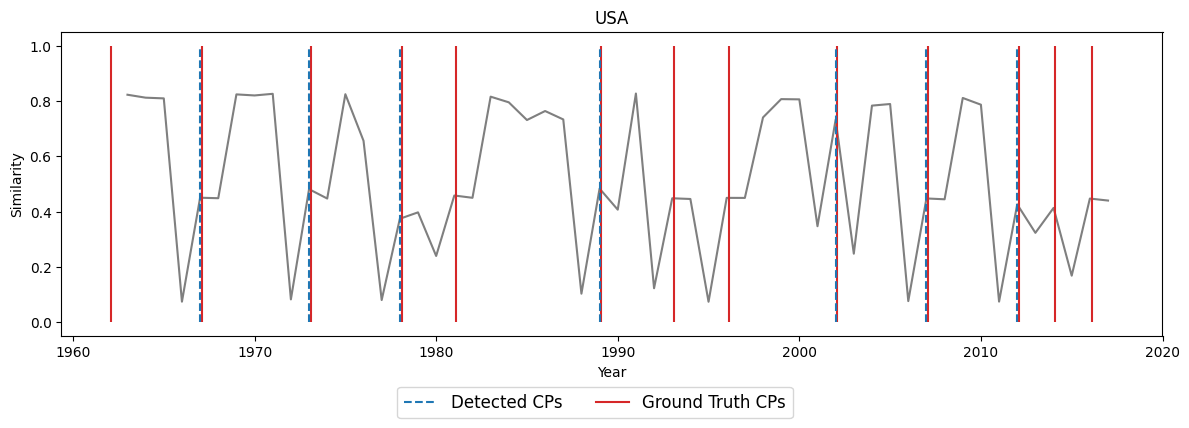

In [66]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
times = range(1963, 2018)
selected_times = crisis_years

# Assuming the region index for USA is 354
region_index = 'USA'

# Plot the similarity scores for USA
ax.plot(times, similarity_scores_norm_gdp[region_index], label='Region USA', color='tab:grey')
adjusted_cps = [i + 0.1 for i in selected_times]

# Plot the true change points and detected change points
ax.vlines(x=adjusted_cps, ymin=0, ymax=1, linestyles='solid', label='True CPs', color='tab:red')
ax.vlines(x=change_points[region_index], ymin=0, ymax=1, linestyles='dashed', label='Detected CPs', color='tab:blue')

# Customize the plot
ax.grid(visible=False)
ax.set_xlabel('Year')
ax.set_ylabel('Similarity')
ax.set_title('USA')
ax.set_xticks(range(1960, 2021, 10))

# Add the legend to the figure
handles = [mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Detected CPs'),
           mlines.Line2D([], [], color='tab:red', linestyle='-', label='Ground Truth CPs')]
fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.08), fontsize='large')

plt.tight_layout()
plt.show()